-----------------------------------------------------------------------------------------------------------------------------


#                                    Déployez un modèle dans le cloud

-----------------------------------------------------------------------------------------------------------------------------

## Problématique

------------------------------------------------------------------------------------------------------------------------
La très jeune start-up de l'AgriTech, nommée "Fruits!",
cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits
en permettant des traitements spécifiques pour chaque espèce de fruits
en développant des robots cueilleurs intelligents.

La start-up souhaite dans un premier temps se faire connaître en mettant
à disposition du grand public une application mobile qui permettrait aux
utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

Pour la start-up, cette application permettrait de sensibiliser le grand public
à la biodiversité des fruits et de mettre en place une première version du moteur
de classification des images de fruits.

De plus, le développement de l’application mobile permettra de construire
une première version de l'architecture Big Data nécessaire.

---------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------
### Objectifs dans ce projet


 - Développer une première chaîne de traitement des données qui
comprendra le preprocessing et une étape de réduction de dimension.
 - Tenir compte du fait que le volume de données va augmentertrès rapidement après la livraison de ce projet, ce qui implique de:
     - Déployer le traitement des données dans un environnement Big Data
     - Développer les scripts en pyspark pour effectuer du calcul distribué
     
------------------------------------------------------------------------------------------------------------------------------     

## Choix techniques généraux retenus


-----------------------------------------------------------------------------------------------------------------------------
### Calcul distribué
L’énoncé du projet nous impose de développer des scripts en pyspark
afin de prendre en compte l’augmentation très rapide du volume
de donné après la livraison du projet.

Pour comprendre rapidement et simplement ce qu’est pyspark
et son principe de fonctionnement, je vous conseille de lire
cet article https://datascientest.com/pyspark

 pySpark est un moyen de communiquer
avec Spark via le langage Python.
Spark, quant à lui, est un outil qui permet de gérer et de coordonner
l'exécution de tâches sur des données à travers un groupe d'ordinateurs.
Spark (ou Apache Spark) est un framework open source de calcul distribué
in-memory pour le traitement et l'analyse de données massives.

-------------------------------------------------------------------------------------------------------------------------------

### Transfert Learning

L'énoncé du projet nous demande également de
réaliser une première chaîne de traitement
des données qui comprendra le preprocessing et
une étape de réduction de dimension.

Il est également précisé qu'il n'est pas nécessaire
d'entraîner un modèle pour le moment.

Je décide de partir sur une solution de transfert learning.

Simplement, le transfert learning consiste
à utiliser la connaissance déjà acquise
par un modèle entraîné (VGG16) pour
l'adapter à notre problématique.

Nous allons fournir au modèle nos images, et nous allons
récupérer l'avant dernière couche du modèle.
En effet la dernière couche de modèle est une couche softmax
qui permet la classification des images ce que nous ne
souhaitons pas dans ce projet.

-----------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------

## Déploiement de la solution sur le cloud



### Choix du prestataire cloud : AWS

Le prestataire le plus connu et qui offre à ce jour l'offre
la plus large dans le cloud computing est Amazon Web Services (AWS).
Certaines de leurs offres sont parfaitement adaptées à notre problématique


L'objectif premier est de pouvoir, grâce à AWS, louer de la puissance de calcul à la demande.
L'idée étant de pouvoir, quel que soit la charge de travail,
obtenir suffisamment de puissance de calcul pour pouvoir traiter nos images,
même si le volume de données venait à fortement augmenter.

De plus, la capacité d'utiliser cette puissance de calcul à la demande
permet de diminuer drastiquement les coûts si l'on compare les coûts d'une location
de serveur complet sur une durée fixe (1 mois, 1 année par exemple).



#### Jupyter Notebook 
https://dataschool.com/data-modeling-101/running-jupyter-notebook-on-an-ec2-server/


#### Installation de Spark
https://www.algaestudy.com/2020/06/setup-spark-on-aws-ubuntu-ec2-virtual.html

---------------------------------------------------------------------------------------------------------------------------

## Import des librairies

---------------------------------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# data handling
from pyspark.sql.functions import element_at, split
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import udf
from pyspark.sql.functions import input_file_name
from pyspark.sql.types import *
from typing import Iterator

# ml tasks
from pyspark.ml.image import ImageSchema
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.feature import  StringIndexer
# transform
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import Vectors, VectorUDT

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Définition des PATH pour charger les images et enregistrer les résultats

Aprés uploader les données de travail sur Amazon S3 , nosdonnées sont stocker sur : **s3://mbdsp8/s3docs/s3_data/**
par la suite j'ai monté mon compartiment S3 en tant que système de fichiers appelé S3fs sur l'instance Linux EC2 déja crée 

S3fs est un système de fichiers FUSE qui vous permet de monter un compartiment Amazon S3 en tant que **système de fichiers local**. Il se comporte comme un lecteur connecté au réseau, car il ne stocke rien sur Amazon EC2, mais l'utilisateur peut accéder aux données sur S3 à partir de l'instance EC2.(https://cloudkul.com/blog/mounting-s3-bucket-linux-ec2-instance/#:~:text=A%20S3%20bucket%20can%20be,on%20S3%20from%20EC2%20instance.)

**Note** : On peut interagir directement avec les ressources AWS par l'utilisation de la bibliothèque **Boto3** avec (S3) qui permet de créer, mettre à jour et supprimer facilement des compartiments S3, des objets, des politiques de compartiment S3 et bien d'autres à partir de programmes ou de scripts Python.
https://medium.com/featurepreneur/using-ec2-services-using-boto3-ad5453fe3bea


In [2]:
PATH_Data = '/home/ubuntu/s3/s3docs/s3_data/' 
PATH_Result = '/home/ubuntu/s3/s3docs/results/'

### Création de la SparkSession

L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé SparkSession.
Une instance de **SparkSession** est la façon dont Spark exécute les fonctions définies par l’utilisateur
dans l’ensemble du cluster. Une SparkSession correspond toujours à une application Spark.

In [3]:
spark = (
        SparkSession
        .builder
        .config("spark.driver.memory", "25g") \
        .config("spark.executor.memory","20g")\
        .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.0')\
        .config("spark.sql.parquet.writeLegacyFormat", 'true')\
        .config('spark.driver.maxResultSize', '20G')
        .master('local') \
        .appName('P8_OC_dc') \
        .getOrCreate()
    ) 
# la variable "**sc**" qui est un **SparkContext** issue de la variable **spark**

sc = spark.sparkContext
    

In [4]:
#Affichage des informations de Spark en cours d'execution
spark

## Traitement des données

### Chargement des données
Les images sont chargées au format binaire, ce qui offre,
plus de souplesse dans la façon de prétraiter les images.

Avant de charger les images, nous spécifions que nous voulons charger
uniquement les fichiers dont l'extension est jpg.

Nous indiquons également de charger tous les objets possibles contenus
dans les sous-dossiers du dossier communiqué.

In [5]:
# J'ai utilisé 5 friuts pour réaliser ce projet. 
#+------------------------+
#|     categorie          |
#+------------------------+
#|Apple_Golden_1          |
#|   Apple_Red_delicios_1 |
#|       apple_6          |
#|          pear_3        |  
#|   apple_pink_lady_1    |
#+-------------------------+

images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

In [6]:
images.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/home/ubuntu...|2022-10-13 01:42:...| 71314|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...|2022-10-13 01:42:...| 70394|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...|2022-10-13 01:42:...| 69986|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...|2022-10-13 01:42:...| 69434|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...|2022-10-13 01:42:...| 69096|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...|2022-10-13 01:42:...| 68201|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...|2022-10-13 01:42:...| 67951|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...|2022-10-13 01:42:...| 66406|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...|2022-10-13 01:42:...| 66312|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...|2022-10-13 01:42:...| 66048|[FF D8 FF E0 00 1...|
|file:/home/ubuntu...|2022-10-13 01:42:...| 64126|[FF D8 FF E0 0

In [7]:
images.count()

762

 conserve que le **path** de l'image et j'ajoute
une colonne contenant les **labels**

In [8]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(6,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------------------------------------+--------------------+
|path                                                              |label               |
+------------------------------------------------------------------+--------------------+
|file:/home/ubuntu/s3/s3docs/s3_data/apple_red_delicios_1/r1_87.jpg|apple_red_delicios_1|
|file:/home/ubuntu/s3/s3docs/s3_data/apple_red_delicios_1/r1_91.jpg|apple_red_delicios_1|
|file:/home/ubuntu/s3/s3docs/s3_data/apple_red_delicios_1/r1_95.jpg|apple_red_delicios_1|
|file:/home/ubuntu/s3/s3docs/s3_data/apple_red_delicios_1/r1_79.jpg|apple_red_delicios_1|
|file:/home/ubuntu/s3/s3docs/s3_data/apple_red_delicios_1/r1_83.jpg|apple_red_delicios_1|
|file:/home/ubuntu/s3/s3docs/s3_data/apple_red_delicios_1/r1_75.jpg|ap

## EXTRACTION DES FEATURES


Nous utilisons ici une approche de featurization de nos images par transfer learning.

Cela consiste à extraire les features les plus pertinentes pour la classification de nos iamges en utilisant un modèle de deep learning pré-entraîné sur de la classification d'image, auquel on enlève la dernière couche - celle qui classifie - afin d'obtenir en sortie un tenseur des features les plus significatives de nos images.

Ce tenseur pourra ensuite être fourni à un autre modèle de classification, qui sera ainsi adapté à nos classes.

Nous utilisons la technique du **transfert learning** pour extraire les features des images.
J'ai choisi d'utiliser le modèle **MobileNetV2** pour sa rapidité d'exécution comparée
à d'autres modèles comme VGG16 par exemple.

L'idée dans ce projet est de récupérer le vecteur de caractéristiques
de dimensions (1,1,1280) qui servira, plus tard, au travers d'un moteur
de classification à reconnaitre les différents fruits du jeu de données.

In [9]:
# modèle
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))
new_model = Model(inputs=model.input,           # en sortie l'avant dernière couche du modèle MobileNetV2
                  outputs=model.layers[-2].output)

Affichage du résumé de notre nouveau modèle 

In [10]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids.
Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser
ensuite les poids aux différents workeurs.

In [11]:
brodcast_weights = sc.broadcast(new_model.get_weights())

In [12]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

### processus de chargement des images et application de leur featurisation à travers l'utilisation de pandas UDF

In [13]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224,224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pyspark/sql/pandas/functions.py:398: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  UserWarning,


### Exécution des actions d'extraction de features

Les Pandas UDF, sur de grands enregistrements (par exemple, de très grandes images),
peuvent rencontrer des erreurs de type Out Of Memory (OOM), pour eviter ce probléme on réduit la taille du lot Arrow via 'maxRecordsPerBatch'

In [14]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

Notre jeu de données de Test contient  762 images.

In [15]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [16]:
features_df.show(10)

+--------------------+--------------------+--------------------+
|                path|               label|            features|
+--------------------+--------------------+--------------------+
|file:/home/ubuntu...|apple_red_delicios_1|[0.047687568, 0.0...|
|file:/home/ubuntu...|              pear_3|[1.5093008, 0.161...|
|file:/home/ubuntu...|              pear_3|[1.3331461, 0.120...|
|file:/home/ubuntu...|apple_red_delicios_1|[1.0500199, 0.135...|
|file:/home/ubuntu...|apple_red_delicios_1|[0.79293156, 0.04...|
|file:/home/ubuntu...|apple_red_delicios_1|[0.538971, 0.0273...|
|file:/home/ubuntu...|apple_red_delicios_1|[1.1994946, 0.534...|
|file:/home/ubuntu...|              pear_3|[0.46037886, 0.30...|
|file:/home/ubuntu...|              pear_3|[2.7339845, 0.239...|
|file:/home/ubuntu...|apple_red_delicios_1|[0.1976822, 0.283...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



### REDUCTION DE DIMENION (PCA)

features sont de type array, il faudra la convertir en Type Vector

In [17]:
#Construction d'une User defined Fonction qui transforme les listes de features en vecteurs denses.
array_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

In [18]:
vectorized_df = features_df.withColumn('cnn_vectors', array_to_vector_udf('features'))

In [19]:
vectorized_df.show(6, True)

+--------------------+--------------------+--------------------+--------------------+
|                path|               label|            features|         cnn_vectors|
+--------------------+--------------------+--------------------+--------------------+
|file:/home/ubuntu...|apple_red_delicios_1|[0.047687568, 0.0...|[0.04768756777048...|
|file:/home/ubuntu...|              pear_3|[1.5093008, 0.161...|[1.50930082798004...|
|file:/home/ubuntu...|              pear_3|[1.3331461, 0.120...|[1.33314609527587...|
|file:/home/ubuntu...|apple_red_delicios_1|[1.0500199, 0.135...|[1.05001986026763...|
|file:/home/ubuntu...|apple_red_delicios_1|[0.79293156, 0.04...|[0.79293155670166...|
|file:/home/ubuntu...|apple_red_delicios_1|[0.538971, 0.0273...|[0.53897100687026...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 6 rows



In [20]:
row_ = vectorized_df.select("features").take(1)

In [21]:
# nombre de features 
# cette partie est à supprimé
print(" le nombre de features par image est de: ", len(row_[0][0]), "\n", 25*"====")

 le nombre de features par image est de:  1280 


### Recherche du nombre de composantes optimales via l'ACP

In [22]:
# Fonction pour réduction de dimensions PCA
def reduc_dim_pca(features):
    '''Réduction des dimensions PCA sur les feature
    Entrée:
    - features de l\'image
    
    Retour:
    - pca
    - pca_matrix: résultat de la réduction de dimensions
    '''
    # Conversion d'un tableau (array) en vecteur dense
    # Création d'un fonction utilisateur avec udf
    #vector_dense = udf(lambda x: Vectors.dense(x), VectorUDT())
    img_vd_df = features.select("path","label","cnn_vectors")
    
    # PCA
    pca_spark = PCA(inputCol="cnn_vectors", outputCol="features_pca", k=100)
    pca = pca_spark.fit(img_vd_df)
    pca_matrix = pca.transform(img_vd_df)
    
    return pca, pca_matrix

In [23]:
# Fonction pour la réduction de dimension PCA
pca, pca_matrix = reduc_dim_pca(vectorized_df)


In [24]:
pca_matrix.show(20)

+--------------------+--------------------+--------------------+--------------------+
|                path|               label|         cnn_vectors|        features_pca|
+--------------------+--------------------+--------------------+--------------------+
|file:/home/ubuntu...|apple_red_delicios_1|[0.04768756777048...|[5.95245327584726...|
|file:/home/ubuntu...|              pear_3|[1.50930082798004...|[-9.8526575811331...|
|file:/home/ubuntu...|              pear_3|[1.33314609527587...|[-9.7289315579346...|
|file:/home/ubuntu...|apple_red_delicios_1|[1.05001986026763...|[11.7170939503497...|
|file:/home/ubuntu...|apple_red_delicios_1|[0.79293155670166...|[14.0058895162358...|
|file:/home/ubuntu...|apple_red_delicios_1|[0.53897100687026...|[10.7214272358125...|
|file:/home/ubuntu...|apple_red_delicios_1|[1.19949460029602...|[13.3873811352580...|
|file:/home/ubuntu...|              pear_3|[0.46037885546684...|[-11.281437041694...|
|file:/home/ubuntu...|              pear_3|[2.73398447

In [25]:
# Fonction pour l'affichage du diagramme des éboulis PCA
def display_pca_eboulis(pca):
    '''Affichage du diagramme des éboulis sur PCA
    Entrée:
    - pca
    
    Retour:
    - N/A
    '''
    # Variance expliquée
    varexpl = pca.explainedVariance*100
        
    # Affichage de la variance cumulée
    plt.figure(figsize=(11,7))
    plt.bar(np.arange(len(varexpl))+1, varexpl)

    cumSumVar = varexpl.cumsum()
    plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
    plt.axhline(y=90, linestyle="--", 
                color="green",
                linewidth=1)

    limit = 90
    valid_idx = np.where(cumSumVar >= limit)[0]
    min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
    plt.axvline(x=min_plans, linestyle="--", 
                color="green",
                linewidth=1)

    plt.xlabel("Rang de l'axe d'inertie pour les composantes K")
    plt.xticks(np.arange(0,105,5))
    plt.xlim(left=0)
    plt.ylabel("Pourcentage d'inertie")
    plt.title("{}% de la variance totale est expliquée"\
                " par les {} premiers axes".format(limit,
                                            min_plans))
    plt.show(block=False)
        
    return None

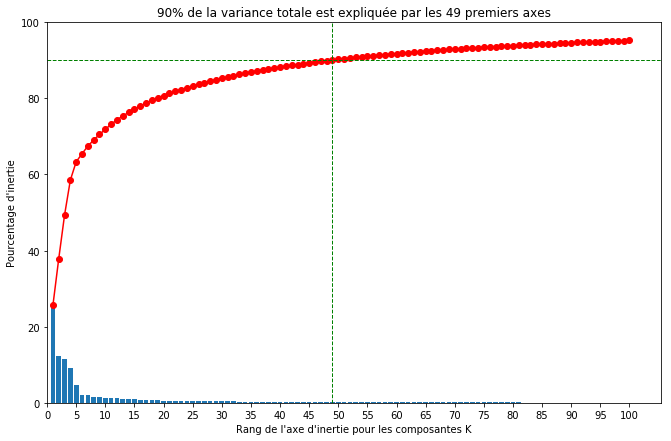

In [26]:
# Affichage du diagramme des éboulis
display_pca_eboulis(pca)

In [27]:
# Transformation inverse (de Vectors à Arrays)
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

In [28]:
final_df = pca_matrix.withColumn('features', vector_to_array_udf('features_pca'))

In [29]:
final_df.show(6, True)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                path|               label|         cnn_vectors|        features_pca|            features|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|file:/home/ubuntu...|apple_red_delicios_1|[0.04768756777048...|[5.95245327584726...|[5.952453, 0.6270...|
|file:/home/ubuntu...|              pear_3|[1.50930082798004...|[-9.8526575811331...|[-9.852657, 1.002...|
|file:/home/ubuntu...|              pear_3|[1.33314609527587...|[-9.7289315579346...|[-9.728931, 0.852...|
|file:/home/ubuntu...|apple_red_delicios_1|[1.05001986026763...|[11.7170939503497...|[11.717094, -0.04...|
|file:/home/ubuntu...|apple_red_delicios_1|[0.79293155670166...|[14.0058895162358...|[14.00589, -2.947...|
|file:/home/ubuntu...|apple_red_delicios_1|[0.53897100687026...|[10.7214272358125...|[10.721427, -2.59...|
+--------------------+---------------

#### Enregistrement des données traitées au format "**parquet**" 

In [30]:
# Enregistrement des données (format parquet)
final_df.write.mode('overwrite').parquet(PATH_Result)

 #### Chargement des données enregistrées et validation du résultat

In [31]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

In [32]:
df

,path,label,cnn_vectors,features_pca,features
0,file:/home/ubuntu/s3/s3docs/s3_data/apple_red_...,apple_red_delicios_1,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[5.952453, 0.6270266, -2.6987433, 0.72456586, ..."
1,file:/home/ubuntu/s3/s3docs/s3_data/pear_3/r0_...,pear_3,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-9.852657, 1.0021753, -10.119265, 11.842184, ..."
2,file:/home/ubuntu/s3/s3docs/s3_data/pear_3/r0_...,pear_3,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-9.728931, 0.8529038, -9.950814, 11.120686, -..."
3,file:/home/ubuntu/s3/s3docs/s3_data/apple_red_...,apple_red_delicios_1,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[11.717094, -0.042775977, 0.009256785, 9.97489..."
4,file:/home/ubuntu/s3/s3docs/s3_data/apple_red_...,apple_red_delicios_1,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[14.00589, -2.947756, 3.3486292, 12.432281, -0..."
...,...,...,...,...,...
757,file:/home/ubuntu/s3/s3docs/s3_data/apple_6/r1...,apple_6,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-0.49023572, -12.608999, -6.6452684, 0.672032..."
758,file:/home/ubuntu/s3/s3docs/s3_data/apple_6/r0...,apple_6,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[1.120374, -13.809594, -4.947166, 2.360319, -0..."
759,file:/home/ubuntu/s3/s3docs/s3_data/apple_6/r1...,apple_6,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-0.60262215, -13.270733, -5.8172874, 5.194395..."
760,file:/home/ubuntu/s3/s3docs/s3_data/apple_6/r0...,apple_6,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[1.7655927, -14.745237, -6.0177345, 5.3917665,..."


### Arrêt de la session Spark
Arrêt de la session Spark pour permettre la libération des ressources (mémoire Java, processeur,...).

In [ ]:
# Arrêt de la session Spark
spark.stop()